# Forward Simulation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

torch.manual_seed(123)

In [ ]:
# exact solution
def sir_model(y, t, beta, gamma):
    S, I, R = y
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I
    return dS_dt, dI_dt, dR_dt

In [ ]:
def simulate_data(beta, gamma, T, num_samples, S0, I0, R0):
    t = np.linspace(0, T, num_samples).reshape(-1, 1)
    y0 = [S0, I0, R0]
    params = (beta, gamma)
    y = odeint(sir_model, y0, t.flatten(), args=params)
    S_data, I_data, R_data = y.T

    data_to_save = pd.DataFrame({'time': t.flatten(), 'Susceptible': S_data, 'Infected': I_data, 'Recovered': R_data})
    data_to_save.to_csv('sir_data_generated.csv', index=False)

    return t, S_data, I_data, R_data

In [ ]:
# model initialization
class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [ ]:
beta = 0.5  # Infection rate
gamma = 0.05  # Recovery rate
T = 100  # Total time
num_samples = 120  # Number of samples
S_0 = 0.99  # Initial susceptible population
I_0 = 0.01  # Initial infected population
R_0 = 0.0  # Initial recovered population
test_size = 0.8

# Simulate data
t, S_data, I_data, R_data = simulate_data(beta, gamma, T, num_samples, S_0, I_0, R_0)

In [ ]:
t_to_tensor = torch.tensor(t, requires_grad=True).view(-1,1)
S_data_to_tensor = torch.tensor(S_data).view(-1,1)
I_data_to_tensor = torch.tensor(I_data).view(-1,1)
R_data_to_tensor = torch.tensor(R_data).view(-1,1)
slide_point = int(num_samples*(1-test_size)) # 23 for test_size = 0.8
t_boundary = torch.tensor(t_to_tensor[:slide_point], requires_grad=True).view(-1,1) #[0:23]
t_physics = t_to_tensor # [0, n_samples] n_samples >> 23
S_true = torch.tensor(S_data_to_tensor[:slide_point]).view(-1,1)
I_true = torch.tensor(I_data_to_tensor[:slide_point]).view(-1,1)
R_true = torch.tensor(R_data_to_tensor[:slide_point]).view(-1,1)
# for prediction and evaluation
time_steps = torch.arange(0, len(t)).numpy() # check again, maybe use time instead of no. step

# TODO: visualize the training data over here

<ipython-input-6-0b7f46a778c3>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_boundary = torch.tensor(t_to_tensor[:slide_point], requires_grad=True).view(-1,1) #[0:23]
<ipython-input-6-0b7f46a778c3>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  S_true = torch.tensor(S_data_to_tensor[:slide_point]).view(-1,1)
<ipython-input-6-0b7f46a778c3>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  I_true = torch.tensor(I_data_to_tensor[:slide_point]).view(-1,1)
<ipython-input-6-0b7f46a778c3>:10: UserWarning: To copy construct from a tensor, i

Total loss:  1.79406 | Physics Loss:  0.00088 | Boundary Loss:  2.56257


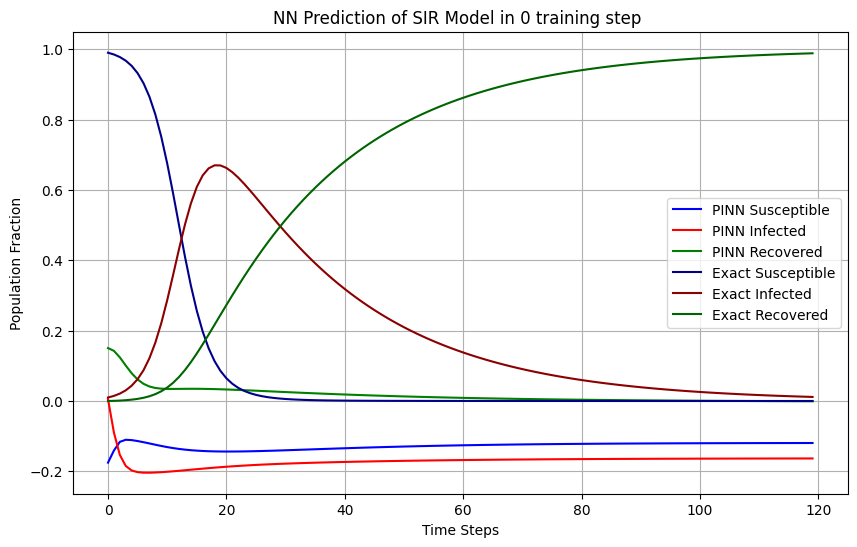

Total loss:  0.0 | Physics Loss:  0.0 | Boundary Loss:  0.0


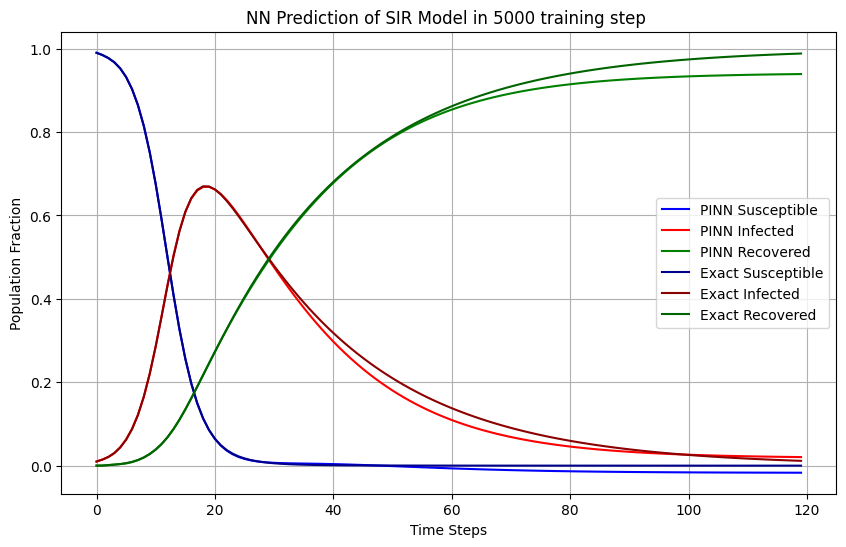

Total loss:  1e-05 | Physics Loss:  0.0 | Boundary Loss:  2e-05


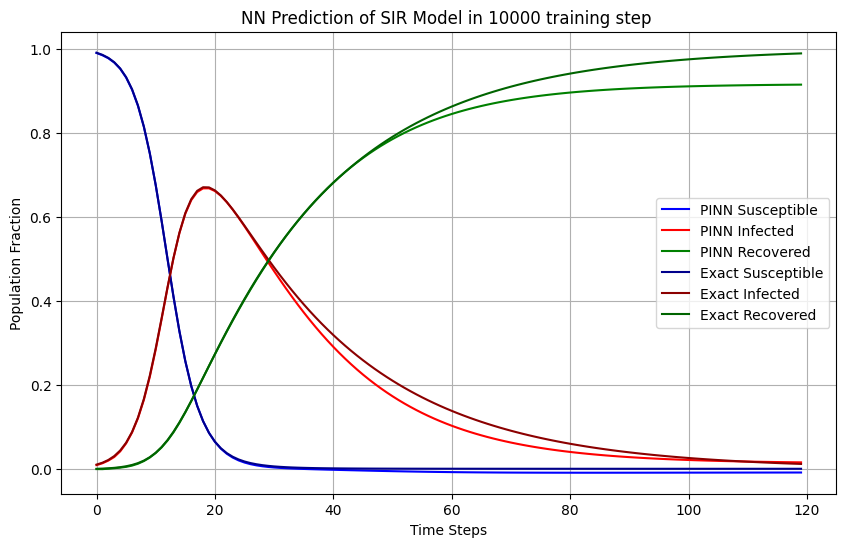

Total loss:  0.0 | Physics Loss:  0.0 | Boundary Loss:  0.0


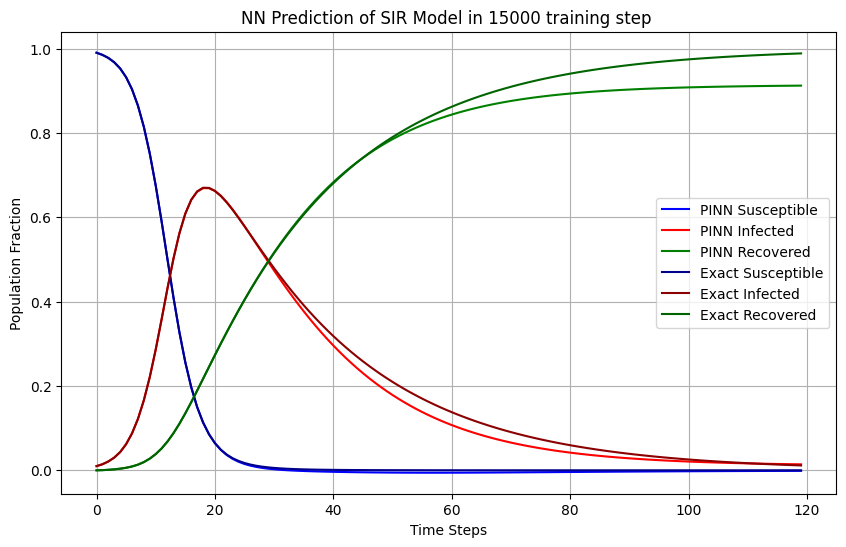

In [ ]:
 # pinn model initialization
pinn = FCN(1,3,32,3)
pinn = pinn.double() # convert input to double
optimizer = torch.optim.Adam(pinn.parameters(),lr=1e-3)
total_loss_list = []
epochs = 15001
# training loop
for i in range(epochs):
    pinn.train()
    optimizer.zero_grad()

    lambda1, lambda2 = 0.7, 0.3

    # compute boundary loss
    u_pinn = pinn(t_boundary)
    S_pred = u_pinn[:, 0:1]
    I_pred = u_pinn[:, 1:2]
    R_pred = u_pinn[:, 2:3]

    boundary_loss = torch.mean((S_pred - S_true)**2)
    #loss1 += torch.squeeze((S_pred-S_true)**2)
    boundary_loss += torch.mean((I_pred - I_true)**2)
    boundary_loss += torch.mean((R_pred - R_true)**2)

    # another boundary for S + I + R = 1
    boundary_loss += torch.mean((S_pred+I_pred+R_pred - 1)**2)

    # compute physics loss
    u_pinn = pinn(t_physics)
    S_pred = u_pinn[:, 0:1]
    I_pred = u_pinn[:, 1:2]
    R_pred = u_pinn[:, 2:3]
    dSdt = torch.autograd.grad(S_pred,t_physics, torch.ones_like(S_pred), create_graph=True)[0]
    dIdt = torch.autograd.grad(I_pred,t_physics, torch.ones_like(I_pred), create_graph=True)[0]
    dRdt = torch.autograd.grad(R_pred,t_physics, torch.ones_like(R_pred), create_graph=True)[0]

    physics_loss = torch.mean((dSdt + beta*S_pred*I_pred)**2)
    physics_loss += torch.mean((dIdt - beta*S_pred*I_pred + gamma*I_pred)**2)
    physics_loss += torch.mean((dRdt - gamma*I_pred)**2)

    total_loss = lambda1*boundary_loss + lambda2*physics_loss
    total_loss_list.append(total_loss.item())

    if i % 5000 == 0:
        print("Total loss: ", round(total_loss.item(), 5), "| Physics Loss: ", round(physics_loss.item(), 5), "| Boundary Loss: ", round(boundary_loss.item() , 5))

        u_pinn_pred = pinn(t_to_tensor).detach()

        S = u_pinn_pred[:, 0].numpy()
        I = u_pinn_pred[:, 1].numpy()
        R = u_pinn_pred[:, 2].numpy()

        # visualize the PINN Prediction over training steps
        plt.figure(figsize=(10,6))
        plt.plot(time_steps, S, label="PINN Susceptible", color="blue")
        plt.plot(time_steps, I, label="PINN Infected", color="red")
        plt.plot(time_steps, R, label="PINN Recovered", color="green")

        plt.plot(time_steps, S_data, label="Exact Susceptible", color="darkblue")
        plt.plot(time_steps, I_data, label="Exact Infected", color="darkred")
        plt.plot(time_steps, R_data, label="Exact Recovered", color="darkgreen")

        plt.xlabel("Time Steps")
        plt.ylabel("Population Fraction")
        plt.title(f"NN Prediction of SIR Model in {i} training step ")
        plt.grid(True)
        plt.legend()
        plt.show()

    total_loss.backward()
    optimizer.step()

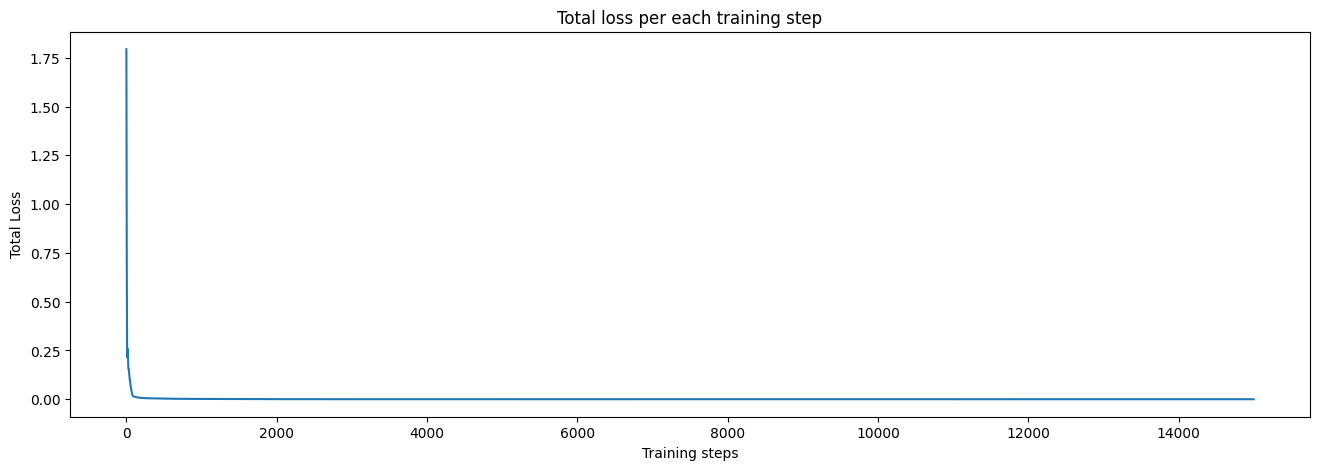

In [ ]:
# plot loss over time
plt.figure(figsize=(16, 5))
plt.plot(range(epochs),total_loss_list)
plt.title("Total loss per each training step")
plt.xlabel("Training steps")
plt.ylabel("Total Loss")
plt.show()

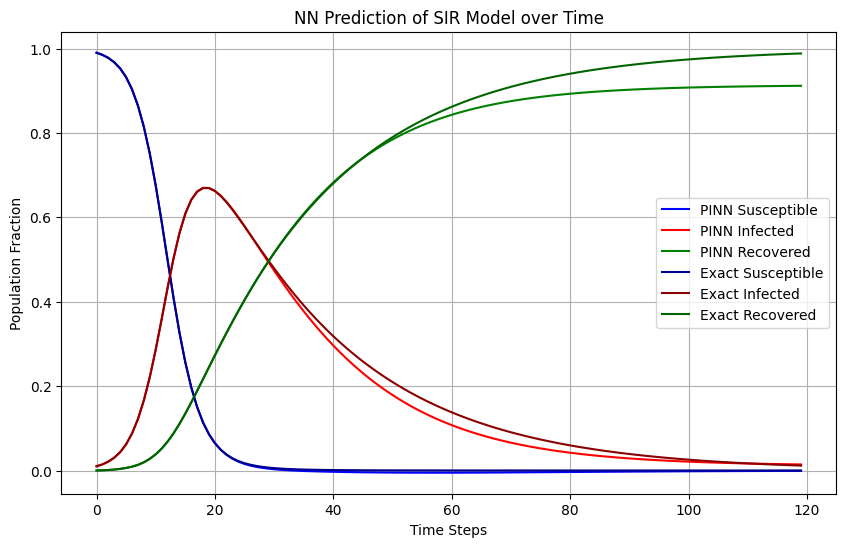

In [ ]:
# make prediction

pinn.eval()
with torch.no_grad():

  t_pred = torch.tensor(t)
  u_pred = pinn(t_pred) # make prediction on all time step

  S_pred = u_pred[:, 0].numpy()
  I_pred = u_pred[:, 1].numpy()
  R_pred = u_pred[:, 2].numpy()


plt.figure(figsize=(10,6))
plt.plot(time_steps, S, label="PINN Susceptible", color="blue")
plt.plot(time_steps, I, label="PINN Infected", color="red")
plt.plot(time_steps, R, label="PINN Recovered", color="green")

plt.plot(time_steps, S_data, label="Exact Susceptible", color="darkblue")
plt.plot(time_steps, I_data, label="Exact Infected", color="darkred")
plt.plot(time_steps, R_data, label="Exact Recovered", color="darkgreen")

plt.xlabel("Time Steps")
plt.ylabel("Population Fraction")
plt.title("NN Prediction of SIR Model over Time")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# model evaluate
MSE_S = np.mean((S_data - S_pred)**2)
MSE_I = np.mean((I_data - I_pred)**2)
MSE_R = np.mean((R_data - R_pred)**2)
Total_MSE = MSE_S + MSE_R + MSE_R

print(f"Total MSE: {Total_MSE}")

# multiply input to 100. Hypothesis: loss x 100^2

Total MSE: 0.0032725743073398306


In [ ]:
# visualization

# Inverse Problem

True value of beta: 0.6


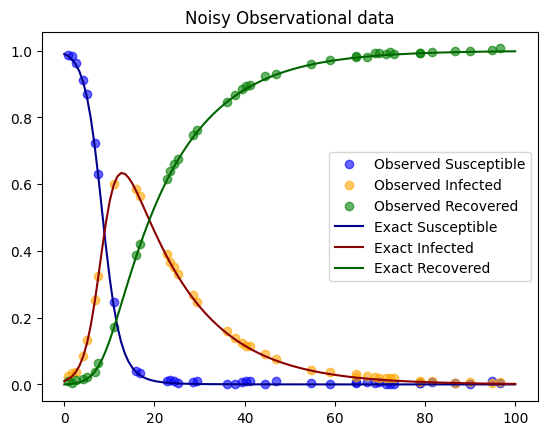

In [ ]:
# creat some noisy observational data
beta = 0.6
gamma = 0.07

num_time_steps = torch.rand(len(t)).view(-1,1)
t_true, S_true, I_true, R_true = simulate_data(beta, gamma, T, num_samples, S_0, I_0, R_0)

random_indices = np.random.choice(len(t_true), size=40, replace=True)
t_obs = t_true[random_indices]
S_obs = S_true[random_indices]
I_obs = I_true[random_indices]
R_obs = R_true[random_indices]

# add some guassian noise
S_obs += 0.01*torch.squeeze(torch.rand(len(S_obs)).view(-1,1)).numpy()
I_obs += 0.01*torch.squeeze(torch.rand(len(I_obs)).view(-1,1)).numpy()
R_obs += 0.01*torch.squeeze(torch.rand(len(R_obs)).view(-1,1)).numpy()

print(f"True value of beta: {beta}")

plt.figure()
plt.title("Noisy Observational data")
plt.scatter(t_obs, S_obs, label="Observed Susceptible", color="blue", alpha=0.6)
plt.scatter(t_obs, I_obs, label="Observed Infected", color="orange",alpha=0.6)
plt.scatter(t_obs, R_obs, label="Observed Recovered", color="green",alpha=0.6)

plt.plot(t_true, S_true, label="Exact Susceptible", color="darkblue")
plt.plot(t_true, I_true, label="Exact Infected", color="darkred")
plt.plot(t_true, R_true, label="Exact Recovered", color="darkgreen")
plt.legend()
plt.show()

In [ ]:
t_true_to_tensor = torch.tensor(t_true, requires_grad=True).view(-1,1)
S_obs_to_tensor = torch.tensor(S_obs).view(-1,1)
I_obs_to_tensor = torch.tensor(I_obs).view(-1,1)
R_obs_to_tensor = torch.tensor(R_obs).view(-1,1)
t_physics = t_true_to_tensor
t_obs_to_tensor = torch.tensor(t_obs, requires_grad=True).view(-1,1)

Total loss:  1.02096 | Physics Loss:  0.00265 | Boundary Loss:  1.45737


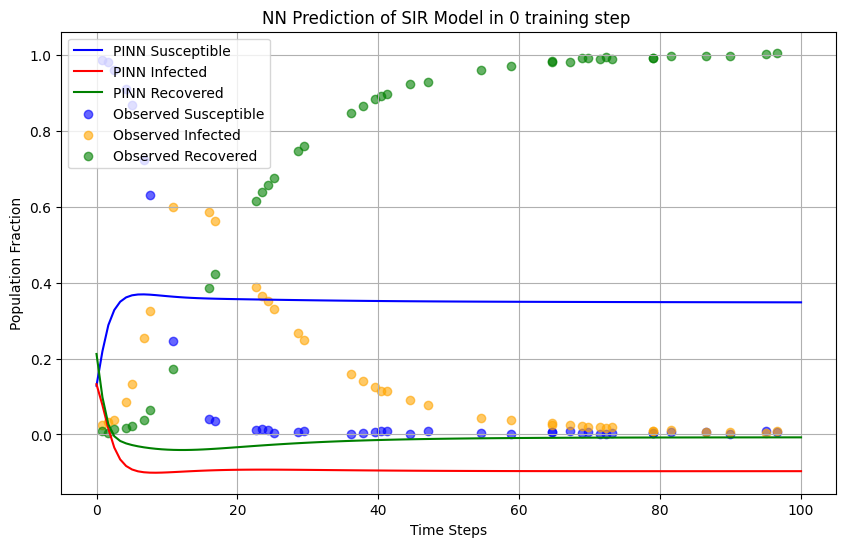

Total loss:  6e-05 | Physics Loss:  0.0 | Boundary Loss:  8e-05


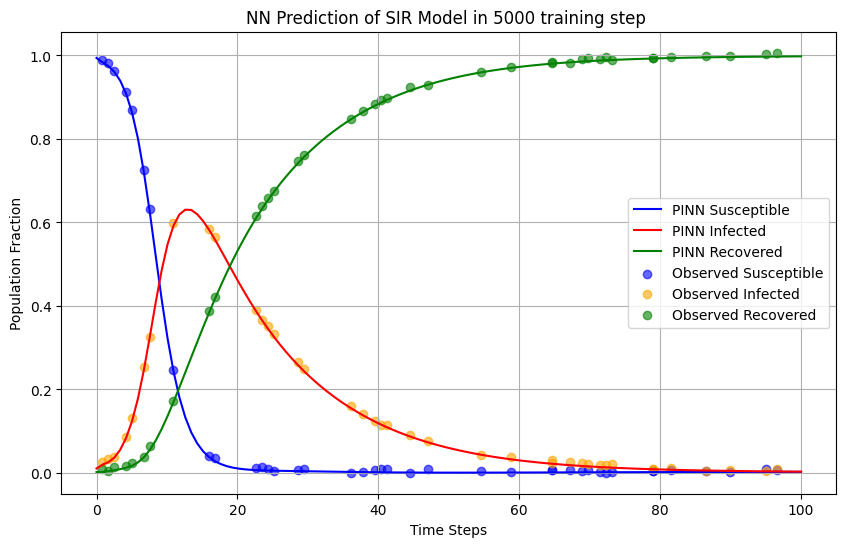

Total loss:  6e-05 | Physics Loss:  0.0 | Boundary Loss:  8e-05


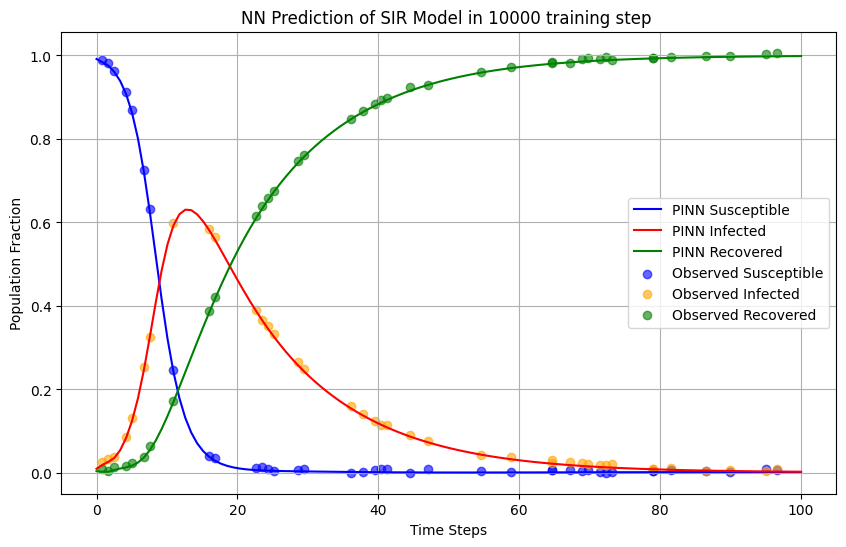

Total loss:  6e-05 | Physics Loss:  0.0 | Boundary Loss:  8e-05


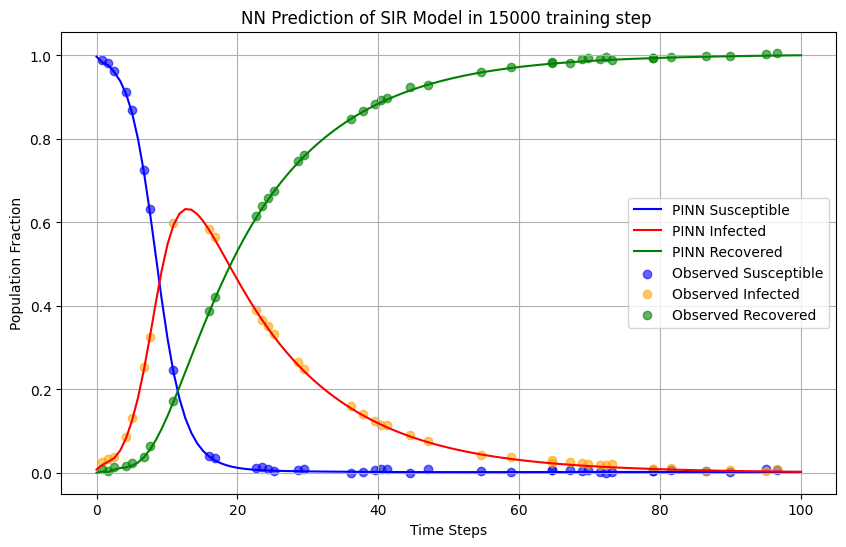

In [ ]:
 # pinn model initialization
pinn = FCN(1,3,32,3)
pinn = pinn.double() # convert input to double
beta_ = torch.nn.Parameter(torch.tensor(1., requires_grad=True))
beta_list = []
total_loss_list = []
epochs = 15001
optimizer = torch.optim.Adam(list(pinn.parameters())+[beta_], lr=1e-3) # add beta into params to learn

# training loop
for i in range(epochs):
    pinn.train()
    optimizer.zero_grad()

    lambda1, lambda2 = 0.7, 0.3

    # compute boundary (data) loss
    u_pinn = pinn(t_obs_to_tensor)
    S_pred = u_pinn[:, 0:1]
    I_pred = u_pinn[:, 1:2]
    R_pred = u_pinn[:, 2:3]

    boundary_loss = torch.mean((S_pred - S_obs_to_tensor)**2)
    boundary_loss += torch.mean((I_pred - I_obs_to_tensor)**2)
    boundary_loss += torch.mean((R_pred - R_obs_to_tensor)**2)

    # another boundary for S + I + R = 1
    boundary_loss += torch.mean((S_pred+I_pred+R_pred - 1)**2)

    # compute physics loss
    u_pinn = pinn(t_physics)
    S_pred = u_pinn[:, 0:1]
    I_pred = u_pinn[:, 1:2]
    R_pred = u_pinn[:, 2:3]
    dSdt = torch.autograd.grad(S_pred,t_physics, torch.ones_like(S_pred), create_graph=True)[0]
    dIdt = torch.autograd.grad(I_pred,t_physics, torch.ones_like(I_pred), create_graph=True)[0]
    dRdt = torch.autograd.grad(R_pred,t_physics, torch.ones_like(R_pred), create_graph=True)[0]

    physics_loss = torch.mean((dSdt + beta_*S_pred*I_pred)**2)
    physics_loss += torch.mean((dIdt - beta_*S_pred*I_pred + gamma*I_pred)**2)
    physics_loss += torch.mean((dRdt - gamma*I_pred)**2)

    total_loss = lambda1*boundary_loss + lambda2*physics_loss
    total_loss_list.append(total_loss.item())

    beta_list.append(beta_.item())
    if i % 5000 == 0:
        print("Total loss: ", round(total_loss.item(), 5), "| Physics Loss: ", round(physics_loss.item(), 5), "| Boundary Loss: ", round(boundary_loss.item() , 5))

        u_pinn_pred = pinn(t_true_to_tensor).detach()

        S = u_pinn_pred[:, 0].numpy()
        I = u_pinn_pred[:, 1].numpy()
        R = u_pinn_pred[:, 2].numpy()

        # visualize the PINN Prediction over training steps
        plt.figure(figsize=(10,6))
        plt.plot(t_true, S, label="PINN Susceptible", color="blue")
        plt.plot(t_true, I, label="PINN Infected", color="red")
        plt.plot(t_true, R, label="PINN Recovered", color="green")

        plt.scatter(t_obs, S_obs, label="Observed Susceptible", color="blue", alpha=0.6)
        plt.scatter(t_obs, I_obs, label="Observed Infected", color="orange",alpha=0.6)
        plt.scatter(t_obs, R_obs, label="Observed Recovered", color="green",alpha=0.6)

        plt.xlabel("Time Steps")
        plt.ylabel("Population Fraction")
        plt.title(f"NN Prediction of SIR Model in {i} training step ")
        plt.grid(True)
        plt.legend()
        plt.show()

    total_loss.backward()
    optimizer.step()

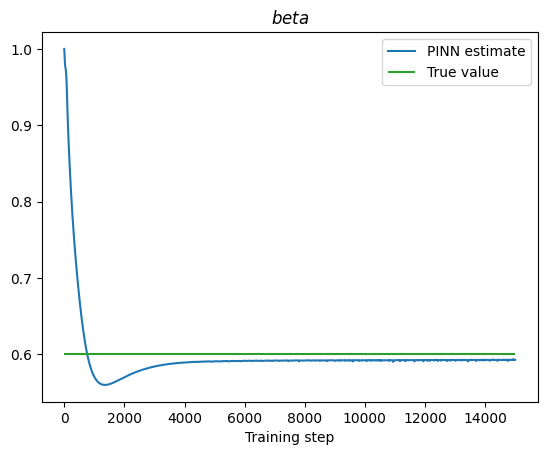

In [ ]:
plt.figure()
plt.title("$beta$")
plt.plot(beta_list, label="PINN estimate")
plt.hlines(beta, 0, len(beta_list), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()